## Doctor appointment booking System
### This is Lang-Graph agent that can book appointments, cancel appointment and change the appointment based on user query  

In [1]:
# import relevant python libraries 
import json
from pprint import pprint
from typing import Annotated
from typing_extensions import TypedDict

# import the langchain libraries
from langchain_core.tools import tool
from langchain_core.messages import ToolMessage
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.graph.message import add_messages,BaseMessage
from langgraph.prebuilt import InjectedStore, ToolNode
from langchain_ollama import ChatOllama

In [2]:
# initialize the ollama chat model
llm = ChatOllama(
    model = "llama3.2:latest",
    temperature = 0.8,
    num_predict = 256,
)
# llm_with_tools = llm.bind_tools([multiply])

In [3]:
from langchain_core.tools import tool

@tool
def multiply(a: int, b: int) -> int:
   """Multiply two numbers."""
   return a * b

In [4]:
messages = [
    ("system", "You are a helpful translator. Translate the user sentence to French."),
    ("human", "I love programming."),
]
response = llm.invoke(messages)

In [5]:
response.tool_calls

[]

### 1. What is TypedDict
A TypedDict type represents dictionary objects with a specific set of string keys, and with specific value types for each valid key. Each string key can be either required (it must be present) or non-required (it doesn’t need to exist).


Annotated in python allows developers to declare the type of a reference and provide additional information related to it.

name: Annotated[str, "first letter is capital"]

In [6]:
import getpass
import os

if "GOOGLE_API_KEY" not in os.environ:
    os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter your Google AI API key: ")

In [3]:
%pip install -qU langchain-google-genai

Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain-community 0.3.18 requires langchain<1.0.0,>=0.3.19, but you have langchain 0.3.17 which is incompatible.


In [7]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash-001",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    # other params...
)

In [7]:
class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]
    


graph_builder = StateGraph(State)

Our graph can now handle two key tasks:

1.Each node can receive the current State as input and output an update to the state.

2.Updates to messages will be appended to the existing list rather than overwriting it, thanks to the prebuilt add_messages function used with the Annotated syntax.

In [8]:
# build sample state graph using lang graph
# The tool abstraction in LangChain associates a Python function with a schema that defines the function's name, 
# description and expected arguments.
@tool
def get_weather(city: str):
    """Get the weather for a specific city"""
    return f"It's sunny in {city}!"

# This wraps the model so it can extract the structured input (like "city") needed for get_weather.
# With this model can extract the from message specific format
model = llm.with_structured_output(get_weather)

Key 'title' is not supported in schema, ignoring
c:\Users\janit\anaconda3\envs\torchenv\Lib\site-packages\langchain_google_genai\chat_models.py:1410: UserWarning: ChatGoogleGenerativeAI.with_structured_output with dict schema has changed recently to align with behavior of other LangChain chat models. More context: https://github.com/langchain-ai/langchain-google/pull/772
  warnings.warn(


In [9]:
# this is subgraph state model
# in the sub graph it use the state of city addition to the messages
class SubGraphState(MessagesState):
    city: str

In [10]:
# this node update the state with the city 
def model_node(state: SubGraphState):
    result = model.invoke(state["messages"])
    return {"city": result["city"]}

In [11]:
# this node execute the tool with the argument
def weather_node(state: SubGraphState):
    result = get_weather.invoke({"city": state["city"]})
    return {"messages": [{"role": "assistant", "content": result}]}

In [12]:
subgraph = StateGraph(SubGraphState)
subgraph.add_node(model_node)
subgraph.add_node(weather_node)
subgraph.add_edge(START, "model_node")
subgraph.add_edge("model_node", "weather_node")
subgraph.add_edge("weather_node", END)
subgraph = subgraph.compile(interrupt_before=["weather_node"])

### 2. Make the Graph to appointment booking
#### 2.1 Function calling with missing parameters

there are some occasions user will only provide some of the parameters only in the user query at that time we need to get other parameters without add them using hallucinations.

- Define Tool Input Schema with Pydantic : Utilize Pydantic's BaseModel to define the expected inputs for your tool. This schema will automatically enforce the presence of required fields.

In [8]:
from pydantic import BaseModel, Field
from typing import Annotated
from langchain.tools import tool
from langchain.tools import BaseTool
from typing import Type
from langgraph.types import Command

class CheckAvailabilityInput(BaseModel):
    month: Annotated[int, Field(ge=1, le=12, description="Month of the year (1-12)")]
    date: Annotated[int, Field(ge=1, le=31, description="Day of the month (1-31)")]
    hour: Annotated[int, Field(ge=0, le=23, description="Hour of the day (0-23)")]


In [76]:
from typing import Optional, Type

from langchain.callbacks.manager import (
    AsyncCallbackManagerForToolRun,
    CallbackManagerForToolRun,
)
# tool for appointment booking
class CheckAvailabilityTool(BaseTool):
    name: Type[BaseModel] = "check_availability"
    description: Type[BaseModel] = "Checks if a given date and time is available for booking."
    args_schema: Type[BaseModel] = CheckAvailabilityInput

    def _run(self, month: int, date: int, hour: int, run_manager: Optional[CallbackManagerForToolRun] = None) -> str:
        # dummy method for check the availability of the calendar

        # update the state using given inputs
        Command(
            update={
                # update the state keys
                "month": month,
                "date": date,
                "hour": hour
            }
        )
        return "Date and Time is available. Ask user to proceed the appointment booking at given time and date"

In [77]:
from pydantic import ValidationError

check_availability_tool = CheckAvailabilityTool()
try:
    check_availability_tool.invoke({"month": 4, "date": 15, "hour": 14})
except ValidationError as e:
    missing_fields = [err['loc'][0] for err in e.errors()]
    print(missing_fields)

In [78]:
check_availability_tool = CheckAvailabilityTool()
model_with_tools = llm.bind_tools([check_availability_tool])

In [79]:
# this is subgraph state model
# in the sub graph it use the state of city addition to the messages
class SubGraphState(TypedDict):
    messages: Annotated[list, add_messages]
    month: int
    date: int
    hour: int

# this is conditional function that return tools if tool called
# other wise return end
def should_continue(state: SubGraphState):
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return END

def call_model(state: SubGraphState):
    try:
        month = state["month"]
        day   = state["date"]
        hour  = state["hour"]
        print(f"Parsed date/time → Month: {month}, Date: {day}, Hour: {hour}")
    except KeyError as e:
        # one of the expected keys was missing
        print(f"State key error: missing {e}")
    messages = state["messages"]
    response = model_with_tools.invoke(messages)
    return {"messages": [response]}

In [80]:
class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}

In [81]:
# make the graph
graph_builder = StateGraph(SubGraphState)


# make connection in graph
graph_builder.add_node("chatbot", call_model)

# make a node to execute the tool
tool_node = BasicToolNode(tools=[check_availability_tool])
graph_builder.add_node("tools", tool_node)

In [82]:
def route_tools(
    state: SubGraphState,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", END: END},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

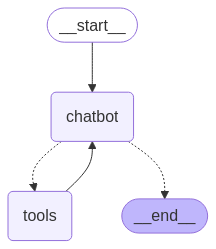

In [83]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [84]:
user_input = "hello?"
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

hello?
State key error: missing 'month'
================================== Ai Message ==================================

Hello! How can I help you today?


In [74]:
user_input = "I want to book an appointment on 23rd march check the availability?"
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I want to book an appointment on 23rd march check the availability?
State key error: missing 'month'
================================== Ai Message ==================================

What hour you would like to book?


In [ ]:
user_input = "i want to book at 6pm"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

i want to book at 6pm
================================== Ai Message ==================================

Okay, I need a bit more information. Which day and month are you looking to book?


In [85]:
user_input = "I want check availability 2025 at march 20 at 5pm?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)

for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

I want check availability 2025 at march 20 at 5pm?
State key error: missing 'month'
================================== Ai Message ==================================
Tool Calls:
  check_availability (0612e6a8-7dfb-4456-ba2d-9aa247230539)
 Call ID: 0612e6a8-7dfb-4456-ba2d-9aa247230539
  Args:
    date: 20.0
    hour: 17.0
    month: 3.0
================================= Tool Message =================================
Name: check_availability

"Date and Time is available. Ask user to proceed the appointment booking at given time and date"
State key error: missing 'month'
================================== Ai Message ==================================

Date and Time is available. Ask user to proceed the appointment booking at given time and date


In [ ]:
user_input = "i want appointment at 5pm on march 20, 2025?"

# Refined prompt to prevent hallucinated arguments
prompt = """
You are an AI assistant. Respond to the user's query strictly based on the provided input.
Reply more politely and helpful way like answer to a phone call.
Do not make assumptions on date, time and month,unless explicitly mentioned in the user's query.
If any wanted information not given in user do not add it in given first message. 
"""

config = {"configurable": {"thread_id": "0"}}

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "system", "content": prompt}, {"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)

for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

i want appointment at 5pm on march 20, 2025?
================================== Ai Message ==================================
Tool Calls:
  check_availability (61dab9c1-ea04-41a1-8085-697db65ca818)
 Call ID: 61dab9c1-ea04-41a1-8085-697db65ca818
  Args:
    date: 20.0
    hour: 17.0
    month: 3.0
================================= Tool Message =================================
Name: check_availability

"Date and Time is available. Ask user to proceed the appointment booking at given time and date"
================================== Ai Message ==================================

Yes, the date and time is available. Would you like to proceed with the appointment booking?


In [49]:
user_input = "Hello! My name is Will."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hello! My name is Will.
================================== Ai Message ==================================

Hi Will! How can I help you today?
